## Water Rights on the Tuolumne River below La Grange

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 600
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.pyplot import cm
import dataretrieval.nwis as nwis
from scipy.signal import argrelextrema
from collections import defaultdict

In [2]:
diversions_annual = pd.read_excel('../water_rights_ewrims/tuol_river_wr.xlsx', sheet_name='Diversions_annual', index_col=0)#, parse_dates=True)
diversions_facevalue = pd.read_excel('../water_rights_ewrims/tuol_river_wr.xlsx', sheet_name='Diversions_facevalue', index_col=0)#, parse_dates=True)
diversions_tuol = pd.read_excel('../water_rights_ewrims/tuol_river_wr.xlsx', sheet_name='Diversions_wrtype', index_col=0)#, parse_dates=True)
diversions_tuol = diversions_tuol.replace('Statement of Div and Use (Riparian claim)', 'Riparian Claim')

In [3]:
# all water rights holders
facevalue_by_type = diversions_tuol['Face_Value_AF.yr'].groupby(diversions_tuol['Water_Right_Type']).sum()
facevalue_by_type_maf = facevalue_by_type/1E6
annualAvgDiv_by_type = diversions_tuol['Avg_Annual_Diversions_MAF'].groupby(diversions_tuol['Water_Right_Type']).sum()

# name of appropriative water rights holders with highest face value
wrholder_names = list(diversions_tuol['Water_Right_Holder'].unique())
#print(wrholder_names)

diversions_tuol_sort = diversions_tuol.sort_values('Face_Value_AF.yr', ascending=False)
top_ten_app_holders = diversions_tuol_sort[0:10]
#print('The top ten approriators based on face-value are', top_ten_app_holders['Water_Right_Holder'])

# NOT turlock holders
not_turlock_holders = diversions_tuol.loc[(diversions_tuol['Water_Right_Holder'] != 'Turlock & Modesto') & (diversions_tuol['Water_Right_Holder'] != 'Turlock Irrigation District')]
#print(not_turlock_holders['Water_Right_Holder'])

# turlock holders only
turlock_holders = diversions_tuol.loc[(diversions_tuol['Water_Right_Holder'] == 'Turlock & Modesto') | (diversions_tuol['Water_Right_Holder'] == 'Turlock Irrigation District')]
#print(turlock_holders['Water_Right_Holder'])

turlock_holders_facevalue = turlock_holders['Face_Value_AF.yr'].groupby(turlock_holders['Water_Right_Type']).sum()
pct_turlock_facevalue = turlock_holders_facevalue['Appropriative']/facevalue_by_type['Appropriative']*100
print('Face-value of water rights held by Turlock & Modesto:', turlock_holders_facevalue['Appropriative']/1E6, 'MAF')
print('Percent of total face-value water rights held by Turlock & Modesto:', pct_turlock_facevalue)

turlock_holders_annualAvgDiv = turlock_holders['Avg_Annual_Diversions_MAF'].groupby(diversions_tuol['Water_Right_Type']).sum()
pct_turlock_annaulAvgDiv_app = turlock_holders_annualAvgDiv['Appropriative']/annualAvgDiv_by_type['Appropriative']*100
pct_turlock_annaulAvgDiv_rip = turlock_holders_annualAvgDiv['Riparian Claim']/annualAvgDiv_by_type['Riparian Claim']*100
print('Actual annaul use of appropriative water rights held by Turlock & Modesto:', turlock_holders_annualAvgDiv['Appropriative']/1E6, 'MAF')
print('Percent of total appropriative water rights held by Turlock & Modesto:', pct_turlock_annaulAvgDiv_app)
print('Actual annaul use of riparian water rights held by Turlock & Modesto:', turlock_holders_annualAvgDiv['Riparian Claim'], 'AF')
print('Percent of total riparian water rights held by Turlock & Modesto:', pct_turlock_annaulAvgDiv_rip)

Face-value of water rights held by Turlock & Modesto: 2.8809282 MAF
Percent of total face-value water rights held by Turlock & Modesto: 99.3060502262604
Actual annaul use of appropriative water rights held by Turlock & Modesto: 0.3859094615384615 MAF
Percent of total appropriative water rights held by Turlock & Modesto: 97.86915322120517
Actual annaul use of riparian water rights held by Turlock & Modesto: 390933.92307692306 AF
Percent of total riparian water rights held by Turlock & Modesto: 97.32061779146596


Appropriative     35
Riparian Claim    31
Certified          5
Name: Water_Right_Type, dtype: int64


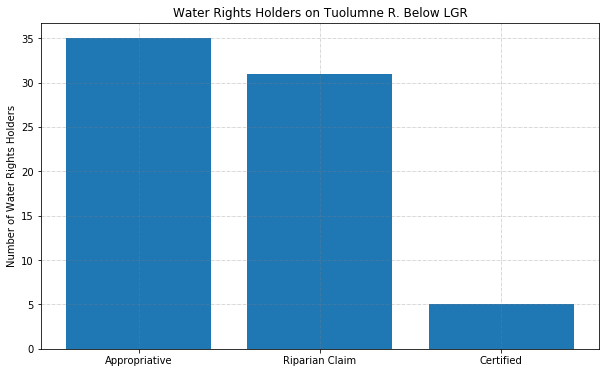

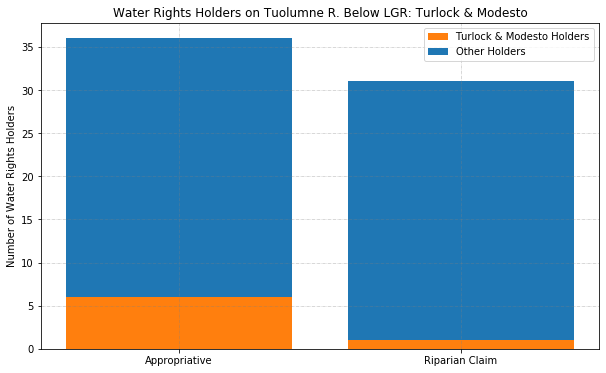

In [4]:
# distribution of water rights holders by type

#wrtypes = list(diversions_tuol['Water_Right_Type'].unique())
holders_per_wrtype = diversions_tuol['Water_Right_Type'].value_counts()
print(holders_per_wrtype)
labels = ['Appropriative', 'Riparian Claim', 'Certified']

file_name = '../results/figures/water_rights/bar_plot_holders.png'
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(labels, holders_per_wrtype)
#ax = holders_per_wrtype.plot(kind='bar')
ax.set_ylabel('Number of Water Rights Holders')
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
plt.title('Water Rights Holders on Tuolumne R. Below LGR')
plt.savefig(file_name, bbox_inches="tight")
plt.show()

not_turlock_holders_per_wrtype = not_turlock_holders['Water_Right_Type'].value_counts()[0:1]
turlock_holders_per_wrtype = turlock_holders['Water_Right_Type'].value_counts()
labels = ['Appropriative', 'Riparian Claim']

file_name = '../results/figures/water_rights/bar_plot_holders_turlock.png'
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(labels, turlock_holders_per_wrtype, color='C1')
ax.bar(labels, not_turlock_holders_per_wrtype, bottom=turlock_holders_per_wrtype)
#ax = holders_per_wrtype.plot(kind='bar')
ax.set_ylabel('Number of Water Rights Holders')
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
plt.legend(['Turlock & Modesto Holders', 'Other Holders'])
plt.title('Water Rights Holders on Tuolumne R. Below LGR: Turlock & Modesto')
plt.savefig(file_name, bbox_inches="tight")
plt.show()

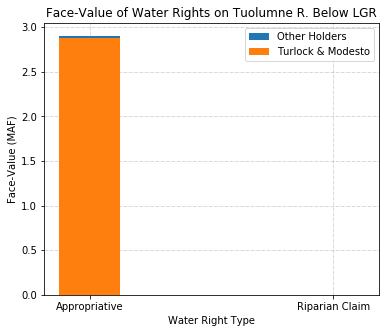

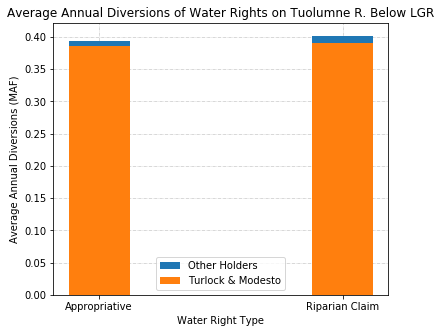

13.591984474343244


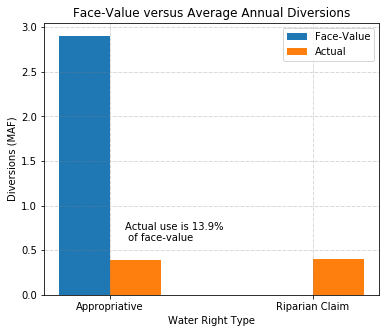

In [5]:
# bar plots comparing appropriative and riparian rights
diversions_tuol = diversions_tuol[diversions_tuol.Water_Right_Type != 'Certified']
labels = ['Appropriative', 'Riparian Claim']
facevalue_by_type = diversions_tuol['Face_Value_AF.yr'].groupby(diversions_tuol['Water_Right_Type']).sum()
facevalue_by_type_maf = facevalue_by_type/1E6
annualAvgDiv_by_type = diversions_tuol['Avg_Annual_Diversions_MAF'].groupby(diversions_tuol['Water_Right_Type']).sum()

n = 2
r = np.arange(n)
width = 0.25

file_name = '../results/figures/water_rights/bar_plot_facevalue_turlock.png'
f, ax = plt.subplots(1,figsize=(6,5))
ax.bar(labels, facevalue_by_type_maf, width=width, color='C0', zorder=3)
ax.bar(labels, turlock_holders_facevalue/1E6, width=width, color='C1', zorder=3)
#ax = facevalue_by_type_maf.plot(kind='bar')
ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel('Face-Value (MAF)')
ax.set_xlabel('Water Right Type')
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6, zorder=0)
plt.legend(['Other Holders', 'Turlock & Modesto'])
plt.title('Face-Value of Water Rights on Tuolumne R. Below LGR')
plt.savefig(file_name, bbox_inches="tight")
plt.show()

file_name = '../results/figures/water_rights/bar_plot_actualuse_turlock.png'
f, ax = plt.subplots(1,figsize=(6,5))
ax.bar(labels, annualAvgDiv_by_type/1E6, width=width, color='C0', zorder=3)
ax.bar(labels, turlock_holders_annualAvgDiv/1E6, width=width, color='C1', zorder=3)
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6, zorder=0)
#ax = annualAvgDiv_by_type.plot(kind='bar', color = 'C1')
ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel('Average Annual Diversions (MAF)')
ax.set_xlabel('Water Right Type')
plt.legend(['Other Holders', 'Turlock & Modesto'])
plt.title('Average Annual Diversions of Water Rights on Tuolumne R. Below LGR')
plt.savefig(file_name, bbox_inches="tight")
plt.show()

pct_actual_app = annualAvgDiv_by_type['Appropriative']/facevalue_by_type['Appropriative']*100
print(pct_actual_app)

file_name = '../results/figures/water_rights/bar_plot_actualuse_vs_facevalue.png'
f, ax = plt.subplots(1,figsize=(6,5))
ax.bar(r, facevalue_by_type/1E6, width=width, label='Face-Value')
ax.bar(r+width, annualAvgDiv_by_type/1E6, width=width, label='Actual')
ax.set_ylabel('Diversions (MAF)')
ax.set_xlabel('Water Right Type')
ax.set_title('Face-Value versus Average Annual Diversions')
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
ax.text(0.2, .600000, 'Actual use is 13.9% \n of face-value')
plt.xticks(r + width/2, labels)
ax.legend()
plt.savefig(file_name, bbox_inches="tight")
plt.show()

In [6]:
facevalue_by_type_maf

Water_Right_Type
Appropriative     2.90106
Riparian Claim    0.00000
Name: Face_Value_AF.yr, dtype: float64

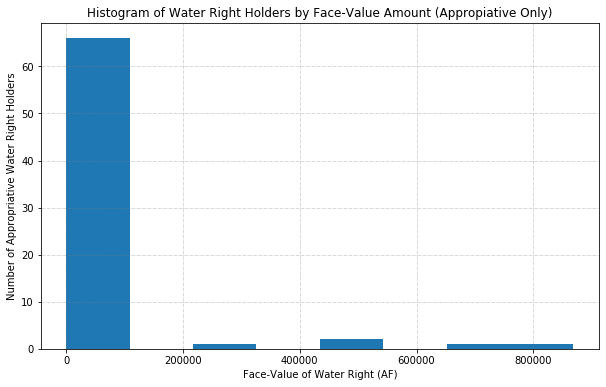

In [7]:
# histogram of appropriative water rights holders by amount
#fig, ax = plt.subplots(dpi=300, figsize=(10,6))

file_name = '../results/figures/water_rights/histogram_appr_holders.png'
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(diversions_facevalue['Face_Value_AF.yr'], bins = 8)#[0, 100000, 200000, 400000, 800000])
ax.set_xlabel('Face-Value of Water Right (AF)')
ax.set_ylabel('Number of Appropriative Water Right Holders')
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
plt.title('Histogram of Water Right Holders by Face-Value Amount (Appropiative Only)')
plt.savefig(file_name, bbox_inches="tight")
plt.show()

In [8]:
# Match application number with water right holder

#diversions_tuol[diversions_tuol['Water_Right_Holder' == 'Turlock & Modesto']]
turlock_holders = diversions_tuol.loc[(diversions_tuol['Water_Right_Holder'] == 'Turlock & Modesto') | (diversions_tuol['Water_Right_Holder'] == 'Turlock Irrigation District')]
turlock_holders_app_numbers = turlock_holders.index.tolist()
turlock_holders_app_numbers

['A006711', 'A003648', 'A003139', 'A009997', 'A009996', 'S013848', 'A001233']

In [9]:
#diversions_annual_holders = pd.read_excel('../water_rights_ewrims/tuol_river_wr.xlsx', sheet_name='Diversions_annual_holders', index_col=0)#, parse_dates=True)
#diversions_annual_holders

diversions_annual_turlock = diversions_annual[turlock_holders_app_numbers]
print(diversions_annual_turlock)
# A033277

diversions_annual_not_turlock = diversions_annual.drop(columns=turlock_holders_app_numbers)
print(diversions_annual_not_turlock)

       A006711  A003648   A003139  A009997  A009996   S013848   A001233
Year                                                                   
2023       NaN      NaN       NaN      NaN      NaN       NaN       NaN
2022   18306.0   4249.0   51585.0      0.0      0.0  326953.0  325000.0
2021   41850.0   8952.0   60973.0      0.0      0.0  197078.0   57000.0
2020   65999.0  13352.0  122299.0      0.0   2155.0  306849.0  149000.0
2019   33312.0   9153.0  122299.0      0.0      0.0  587355.0  325000.0
2018   15235.0  10978.0   89255.0      0.0      0.0  429359.0  280000.0
2017   67754.0   8993.0   56579.0   1003.0      0.0  646210.0  325000.0
2016   46167.0   9164.0   88129.0      0.0      0.0  358649.0  325000.0
2015  109575.0  18779.0   73541.0      0.0      0.0  124430.0  163897.0
2014   33473.0  17940.0  145619.0      0.0      0.0  158393.0   77468.0
2013   19516.0  10358.0   70217.0      0.0      0.0  328351.0  154492.0
2012   28052.0  10164.0   76086.0      0.0      0.0  318193.0  3

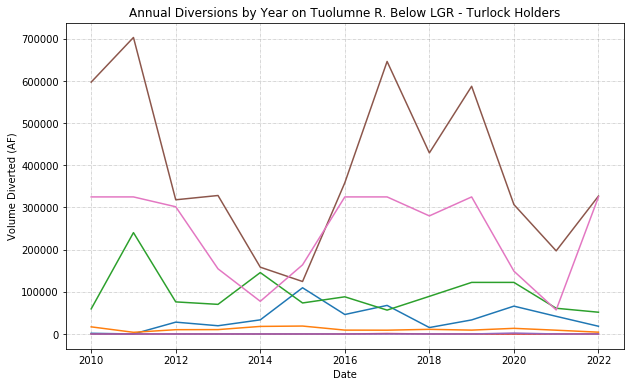

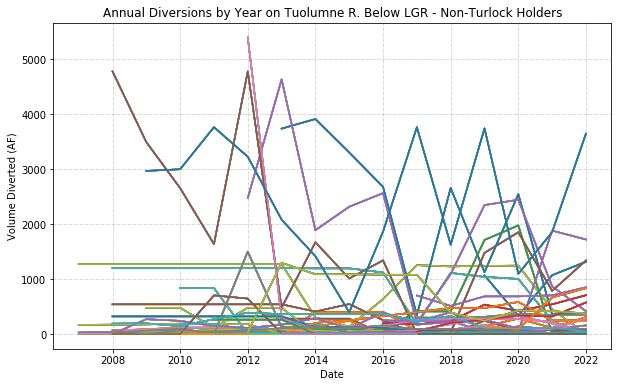

In [10]:
# sum total diversions per year for all water rights holders
#diversions_annual['total'] = diversions_annual.sum(axis=1)
#diversions_annual

# file_name = '../results/figures/water_rights/timeseries_annual_diversions.png'
# fig, ax = plt.subplots(dpi=300, figsize=(10,6))
# for column in diversions_annual_holders.columns:
#     ax.plot(diversions_annual_holders.iloc[:-1,:], label=column)
# ax.grid(b = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.6)
# ax.set_ylabel('Volume Diverted (AF)')
# ax.set_xlabel('Date')
# plt.legend()
# plt.title('Annual Diversions by Year on Tuolumne R. Below LGR')
# plt.savefig(file_name, bbox_inches="tight")
# plt.show()

file_name = '../results/figures/water_rights/timeseries_annual_diversions_turlock.png'
#fig, ax = plt.subplots(dpi=300, figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,6))
#for column in diversions_annual_turlock.columns:
ax.plot(diversions_annual_turlock.iloc[:-1,:])
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
ax.set_ylabel('Volume Diverted (AF)')
ax.set_xlabel('Date')
#plt.legend()
plt.title('Annual Diversions by Year on Tuolumne R. Below LGR - Turlock Holders')
plt.savefig(file_name, bbox_inches="tight")
plt.show()

file_name = '../results/figures/water_rights/timeseries_annual_diversions_not_turlock.png'
fig, ax = plt.subplots(figsize=(10,6))
for column in diversions_annual_turlock.columns:
    ax.plot(diversions_annual_not_turlock.iloc[:-1,:], label=column)
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
ax.set_ylabel('Volume Diverted (AF)')
ax.set_xlabel('Date')
#plt.legend()
plt.title('Annual Diversions by Year on Tuolumne R. Below LGR - Non-Turlock Holders')
plt.savefig(file_name, bbox_inches="tight")
plt.show()

# Add labels to plots, develop plots for monthly data

In [11]:
# Water years
# Create dataframes for WY types
water_year_indices_SVI = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_raw\\water_year_indices_SVI.csv', index_col=0, parse_dates=True)
water_year_indices_SJI = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_raw\\water_year_indices_SJI.csv', index_col=0, parse_dates=True)
WY_SVI = pd.DataFrame(water_year_indices_SVI['WY_type']['1948-01-01':'2023-01-01'])
WY_SJI = pd.DataFrame(water_year_indices_SJI['WY_type']['1923-01-01':'2023-01-01'])

WY_SVI['WY'] = pd.to_datetime(WY_SVI.index)
WY_SJI['WY'] = pd.to_datetime(WY_SJI.index)
WY_SVI['WY'] = WY_SVI['WY'].dt.strftime('%Y')
WY_SJI['WY'] = WY_SJI['WY'].dt.strftime('%Y')
WY_SVI.index.name = 'Date'
WY_SJI.index.name = 'Date'

In [12]:
# Create column of WY
diversions_annual['WY'] = diversions_annual.index
diversions_annual_turlock['WY'] = diversions_annual_turlock.index
diversions_annual_not_turlock['WY'] = diversions_annual_not_turlock.index
#print(diversions_annual_turlock)

# Force WY to be a string in the df
diversions_annual['WY'] = diversions_annual['WY'].astype(str)
diversions_annual_turlock['WY'] = diversions_annual_turlock['WY'].astype(str)
diversions_annual_not_turlock['WY'] = diversions_annual_not_turlock['WY'].astype(str)

# Merge the diversions df with the water year df based on the 'WY' columns in both
diversions_annual = pd.merge(diversions_annual, WY_SJI[['WY', 'WY_type']], left_index=True, on='WY', how='left')
diversions_annual_turlock = pd.merge(diversions_annual_turlock, WY_SJI[['WY', 'WY_type']], left_index=True, on='WY', how='left')
diversions_annual_not_turlock = pd.merge(diversions_annual_not_turlock, WY_SJI[['WY', 'WY_type']], left_index=True, on='WY', how='left')
#diversions_annual_turlock

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [13]:
diversions_annual_not_turlock

,A011438,A017721,A019044,S011102,S011103,S024284,S024721,S024480,A015371,C001796,...,S007652,S009161,A030613,S028237,A033277,S018705,S009071,A031958,WY,WY_type
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,W
2022-01-01,0.0,0.690,0.0,NaN,89.00,4.5,5.150,69.44,0.0,3.0,...,374.3,46.8,3650.0,835.0,NaN,NaN,NaN,NaN,2022,C
2021-01-01,450.0,3.510,0.0,93.60,88.00,4.5,4.390,74.62,0.0,3.0,...,416.3,114.3,1855.0,664.0,NaN,NaN,NaN,NaN,2021,C
2020-01-01,1245.0,0.852,0.0,86.20,80.00,5.5,5.180,68.10,0.0,3.0,...,428.8,94.1,1095.0,92.8,NaN,NaN,NaN,NaN,2020,D
2019-01-01,1240.0,1.404,7.3,87.30,80.00,5.5,5.080,240.60,0.0,3.0,...,240.7,110.5,3745.0,125.4,NaN,NaN,NaN,NaN,2019,W
2018-01-01,1230.0,1.498,26.3,95.40,80.00,5.5,5.080,0.00,0.0,3.0,...,390.6,326.1,1626.0,NaN,NaN,NaN,NaN,NaN,2018,BN
2017-01-01,1252.5,1.498,0.0,66.09,88.38,5.5,4.780,0.00,0.0,3.0,...,1077.0,237.1,3766.0,NaN,NaN,NaN,NaN,NaN,2017,W
2016-01-01,635.7,1.498,0.0,399.77,88.38,5.5,4.415,0.00,0.0,3.0,...,1080.0,369.5,1864.0,NaN,NaN,NaN,NaN,NaN,2016,D
2015-01-01,130.0,1.498,0.0,398.00,88.38,NaN,4.215,278.30,0.0,NaN,...,1087.0,360.6,394.0,NaN,NaN,NaN,NaN,NaN,2015,C


In [14]:
diversions_annual_sum = diversions_annual.sum(axis=1)
diversions_annual_sum / 1E6
#diversions_annual.groupby('WY_type', as_index=False)

Date
2023-01-01    0.000000
2022-01-01    0.740097
2021-01-01    0.378017
2020-01-01    0.677025
2019-01-01    1.095662
2018-01-01    0.837444
2017-01-01    1.116121
2016-01-01    0.841852
2015-01-01    0.502293
2014-01-01    0.447220
2013-01-01    0.601099
2012-01-01    0.757398
2011-01-01    1.284097
2010-01-01    1.011633
2009-01-01    0.011142
2008-01-01    0.008693
2007-01-01    0.001471
2006-01-01    0.000000
2005-01-01    0.000000
2004-01-01    0.000000
2003-01-01    0.000000
2002-01-01    0.000000
2001-01-01    0.000000
2000-01-01    0.000000
1999-01-01    0.000000
1998-01-01    0.000000
1997-01-01    0.000000
1996-01-01    0.000000
1995-01-01    0.000000
1994-01-01    0.000000
dtype: float64

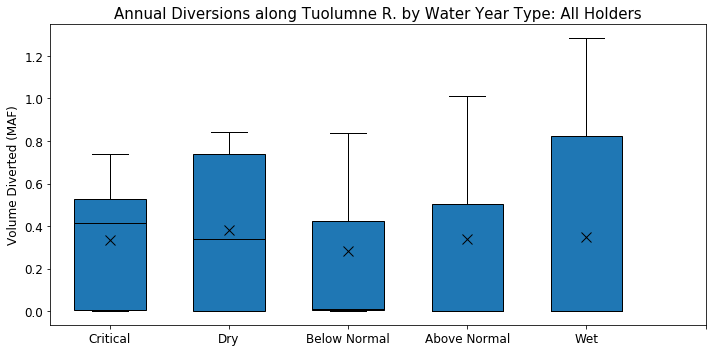

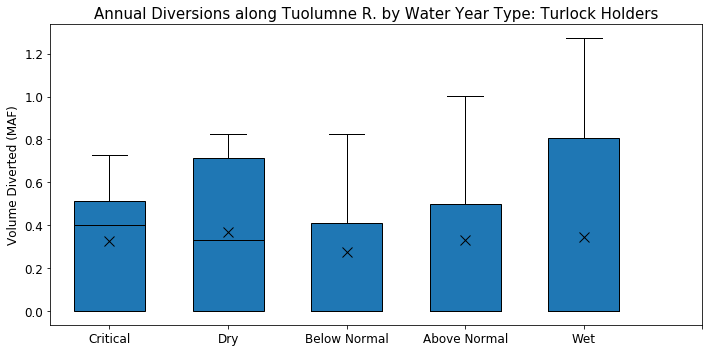

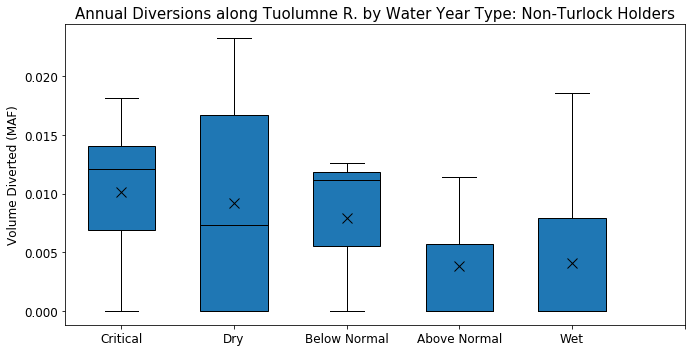

In [15]:
# Plot of annual diversions by water year type

#WYTs = diversions_annual['WY_type'].unique()
WYTs = ['C', 'D', 'BN', 'AN', 'W']
ticks = ['Critical', 'Dry', 'Below Normal', 'Above Normal', 'Wet']
dfs = [diversions_annual, diversions_annual_turlock, diversions_annual_not_turlock]
title_names = ['All Holders', 'Turlock Holders', 'Non-Turlock Holders']

for j, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(10,5))
    
    for i, WYT in enumerate(WYTs):
        selected_df = df[df['WY_type'] == WYT]
        selected_df_sum = selected_df.sum(axis=1)
        ax.boxplot(selected_df_sum / 1E6, positions=[i], widths=0.6, patch_artist=True,
            #boxprops=dict(facecolor='seagreen'), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})
    
    # ax.plot([], c='#feb24c', label='Critical')
    # ax.plot([], c='#3182bd', label='Dry')
    # ax.plot([], c='seagreen', label='Below normal')
    # ax.legend(loc=1, prop={"size":15})

    # customize plot
    plt.xticks([0, 1, 2, 3, 4, 5], ticks, fontsize=12)
    #ax.set_xticks([-1,0], ticks)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylabel('Volume Diverted (MAF)', fontsize=12)
    #plt.xlim(-2, len(ticks)*3)
    plt.title(f'Annual Diversions along Tuolumne R. by Water Year Type: {title_names[j]}', fontsize=15)
    plt.tight_layout()
    
    #file_name = f'../results/figures/box_plots/tuol_compare_flows_{col}.png'
    #plt.savefig(file_name, bbox_inches="tight")
    plt.show()

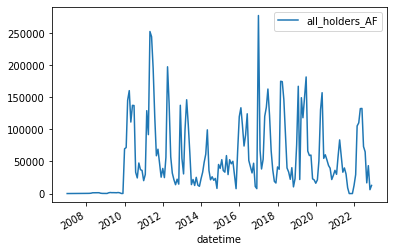

In [16]:
# Monthly diversion data
diversions_monthly = pd.read_excel('../water_rights_ewrims/tuol_river_wr_monthly.xlsx', sheet_name='Diversions_monthly')#, parse_dates=True)
diversions_monthly['datetime'] = pd.to_datetime(diversions_monthly[['year', 'month', 'day']])
diversions_monthly.set_index('datetime', inplace=True)
diversions_monthly = diversions_monthly.drop(['year', 'month', 'day'], axis='columns')
diversions_monthly.plot()

In [33]:
diversions_monthly
#diversions_annual_subset = diversions_annual[div_pts_subset_list]

,all_holders_AF
datetime,
2022-01-01,12655.496
2022-02-01,29551.680
2022-03-01,105403.956
2022-04-01,110225.141
2022-05-01,132442.166
...,...
2007-08-01,198.600
2007-09-01,195.600
2007-10-01,193.600


In [17]:
div_pts = pd.read_excel('../water_rights_ewrims/tuol_river_wr.xlsx', sheet_name='wr_holders_TR')#, parse_dates=True)

def dms_to_decimal(degrees, minutes, seconds, direction):
    decimal_degrees = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    if direction in ['S', 'W']:
        decimal_degrees *= -1  # Make latitude/longitude negative for S/W directions
    return decimal_degrees

lat_11290000 = dms_to_decimal(37, 37, 38, 'N')
long_11290000 = dms_to_decimal(120, 59, 0, 'W')
lat_11289650 = dms_to_decimal(37, 39, 59, 'N')
long_11289650 = dms_to_decimal(120, 26, 28, 'W')

gauges = pd.DataFrame({
    'USGS_ID': ['11289650', '11290000'],
    'LATITUDE': [lat_11289650, lat_11290000],
    'LONGITUDE': [long_11289650, long_11290000]
})

# Define the longitude values for the reference points
east_reference_longitude = gauges['LONGITUDE'][0]  # Example value for east
west_reference_longitude = gauges['LONGITUDE'][1]  # Example value for west

# Find points between the east and west reference longitudes
div_pts_subset = div_pts[(div_pts['LONGITUDE'] > west_reference_longitude) & (div_pts['LONGITUDE'] < east_reference_longitude)]
#div_pts_subset

In [18]:
# Map of sites
import plotly.io as pio
pio.renderers.default = "iframe"

import plotly.express as px
import plotly.graph_objects as go

geojson_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson'

fig = go.Figure(go.Choroplethmapbox(
    geojson=geojson_url,
    #locations=df['County'],
    #z=df['Value'],
    #colorscale='Viridis',
    #zmin=min(df['Value']),
    #zmax=max(df['Value']),
    marker_opacity=0.5,
    marker_line_width=0,
    #colorbar=dict(title='Your Colorbar Title'),
))

# Add scatter map points
fig.add_trace(go.Scattermapbox(
    lat=div_pts_subset['LATITUDE'],
    lon=div_pts_subset['LONGITUDE'],
    mode='markers',
    marker=dict(size=10, color='red'),
    text=div_pts_subset['APPL_ID'],
    name='Diversion points'
))

fig.add_trace(go.Scattermapbox(
    lat=gauges['LATITUDE'],
    lon=gauges['LONGITUDE'],
    mode='markers',
    marker=dict(size=10, color='blue'),
    text=gauges['USGS_ID'],
    name='USGS Gauge'
))

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=5,
    mapbox_center={"lat": 36.7783, "lon": -119.4179},
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

#df = px.data.gapminder().query("year == 2007")
# fig = px.scatter_geo(df, locations="iso_alpha",
#                      size="pop", # size of markers, "pop" is one of the columns of gapminder
#                      )

# fig = px.scatter_geo(div_pts, lat='LATITUDE', lon='LONGITUDE',
#                      hover_name='APPL_ID', #size='mag',
#                      title='Diversion Pts on Tuol. R.')
fig.show()

In [19]:
div_pts_subset_list = div_pts_subset['APPL_ID'].tolist()

In [31]:
diversions_annual_subset = diversions_annual[div_pts_subset_list]

# Reset index to year
diversions_annual_subset['datetime'] = pd.to_datetime(diversions_annual_subset.index)
diversions_annual_subset['Year'] = diversions_annual_subset['datetime'].dt.strftime('%Y') # create year column
diversions_annual_subset.set_index('Year', inplace=True)
columns_to_remove = ['datetime']
diversions_annual_subset = diversions_annual_subset.drop(columns=columns_to_remove)
diversions_annual_subset['sum'] = diversions_annual_subset.sum(axis=1) / 1E6
diversions_annual_subset = diversions_annual_subset.sort_values(by='Year')
diversions_annual_subset.to_csv('tuol_river_subset_annual_flows.csv', index=True)

diversions_annual_subset.head()

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,S007652,S011103,A001233,S011191,S009071,A003648,A012262,A015371,A009996,S014004,...,S021737,S021738,S021739,A031958,S024721,S025745,S025746,S026169,A033277,sum
Year,,,,,,,,,,,,,,,,,,,,,
1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


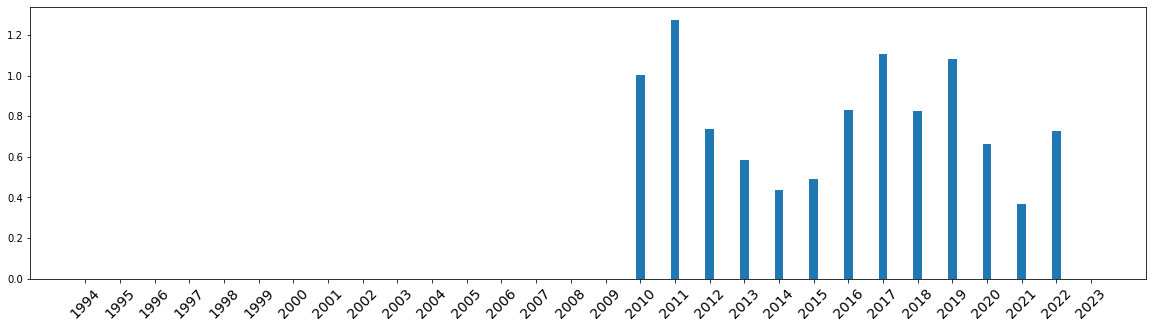

In [32]:
# Create categories for the x-axis
categories = diversions_annual_subset.index.unique()

# Create bar plot
x = np.arange(len(categories)) # Create an array of x positions for the bars

fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x, diversions_annual_subset['sum'], width=0.25)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, fontsize=14)
plt.show()

In [42]:
diversions = pd.read_excel('../water_rights_ewrims/tuol_river_wr.xlsx', sheet_name='Diversions', skiprows=1)#, parse_dates=True)

# Filter rows where 'Application Number' is in the list of div_pts_subset_list
diversions_subset = diversions[diversions['Application Number'].isin(div_pts_subset_list)]

# Save as Excel file
diversions_subset.to_excel('../water_rights_ewrims/tuol_river_subset_flows.xlsx', index=True)

diversions_subset

,Application Number,Permit ID,Water Right Type,Year,Date Received,Jan,Feb,Mar,Apr,May,...,Holder Name,Crop 1,Acre,Crop 2,Acre.1,Crop 3,Acre.2,Comments,Unnamed: 28,Unnamed: 29
0,A006711,4271.0,Appropriative,2022,2023-02-01,0.0,0.0,0.0,0.0,0.0,...,Turlock & Modesto,Multiple,266203,NaN,NaN,NaN,NaN,https://ciwqs.waterboards.ca.gov/ciwqs/ewrims/...,NaN,NaN
1,A006711,NaN,NaN,2021,2022-04-01,0.0,0.0,0.0,0.0,0.0,...,Turlock & Modesto,Multiple,266203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A006711,NaN,NaN,2020,2021-04-01,0.0,0.0,0.0,0.0,0.0,...,Turlock & Modesto,Multiple,266203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A006711,NaN,NaN,2019,2020-04-01,0.0,0.0,0.0,0.0,0.0,...,Turlock & Modesto,Multiple,266203,NaN,NaN,NaN,NaN,NaN,NaN,removed sites with no reports
4,A006711,NaN,NaN,2018,2019-07-01,0.0,0.0,0.0,0.0,0.0,...,Turlock & Modesto,Multiple,266203,NaN,NaN,NaN,NaN,NaN,NaN,C003178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,S009161,NaN,NaN,2012,2014-06-11,5.7,1.2,14.0,19.6,26.1,...,Joseph E Gallo,Grapes,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,S009161,NaN,NaN,2011,2014-06-11,0.0,0.0,0.0,0.0,6.8,...,Joseph E Gallo,Grapes,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,S009161,NaN,NaN,2010,2011-06-30,0.0,0.0,4.2,5.3,0.0,...,Joseph E Gallo,Grapes,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748,S009161,NaN,NaN,2009,2011-06-30,0.0,0.0,8.0,16.0,7.7,...,Joseph E Gallo,Grapes,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN


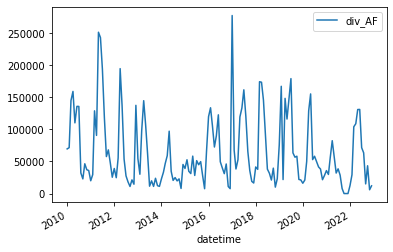

In [43]:
# Monthly diversion data - subset
div_monthly_subset = pd.read_excel('../water_rights_ewrims/tuol_river_subset_monthly_flows.xlsx', sheet_name='div_monthly')#, parse_dates=True)
div_monthly_subset['datetime'] = pd.to_datetime(div_monthly_subset[['year', 'month', 'day']])
div_monthly_subset.set_index('datetime', inplace=True)
div_monthly_subset = div_monthly_subset.drop(['year', 'month', 'day'], axis='columns')
div_monthly_subset.plot()